<a href="https://colab.research.google.com/github/JagritiPrakash/An-Understanding-of-Covid-19-in-India/blob/master/Covid_19Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing the packages: Squarify and Plotly-express**

In [0]:
!pip install squarify

In [0]:
!pip install plotly-express

Importing packages and Algorithms

In [0]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline

**Importing Files from Google Colab. After the first file, rest have been directly uploaded to the files folder on the left hand side, and therefore can be read directly.**

In [0]:
from google.colab import files

In [0]:
upload_files = files.upload()

Saving AgeGroupDetails.csv to AgeGroupDetails.csv


In [0]:
!ls


AgeGroupDetails.csv  sample_data


In [0]:
age_details = pd.read_csv('AgeGroupDetails.csv')

In [0]:
india_covid19 = pd.read_csv('covid19_india.csv')

In [0]:
hospital_beds = pd.read_csv('HospitalBedsIndia.csv')

In [0]:
individual_details = pd.read_csv('IndividualDetails.csv')
ICMR_labs = pd.read_csv('ICMRTestingLabs.csv')
state_testing = pd.read_csv('StatewiseTestingDetails.csv')
population = pd.read_csv('population_india_census2011.csv')
india_covid19['Date'] = pd.to_datetime(india_covid19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])


**Time Series Data for the total number of confirmed, recovered and deaths has been taken from the github account of JHU** 

In [0]:

confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')


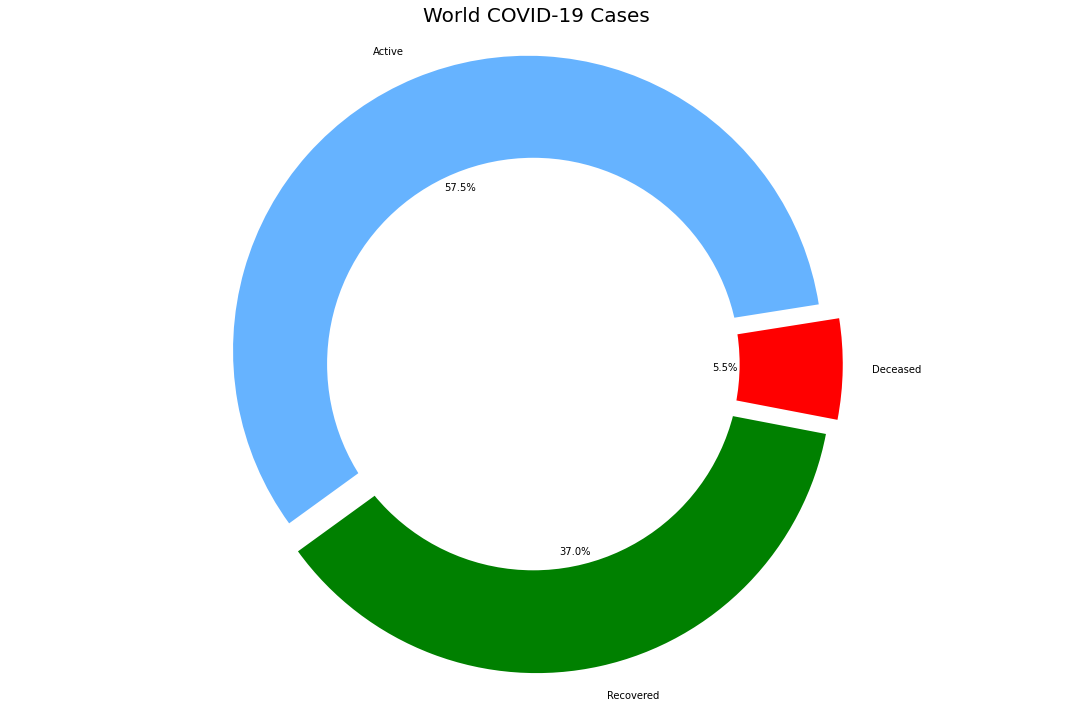

In [0]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)

labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()


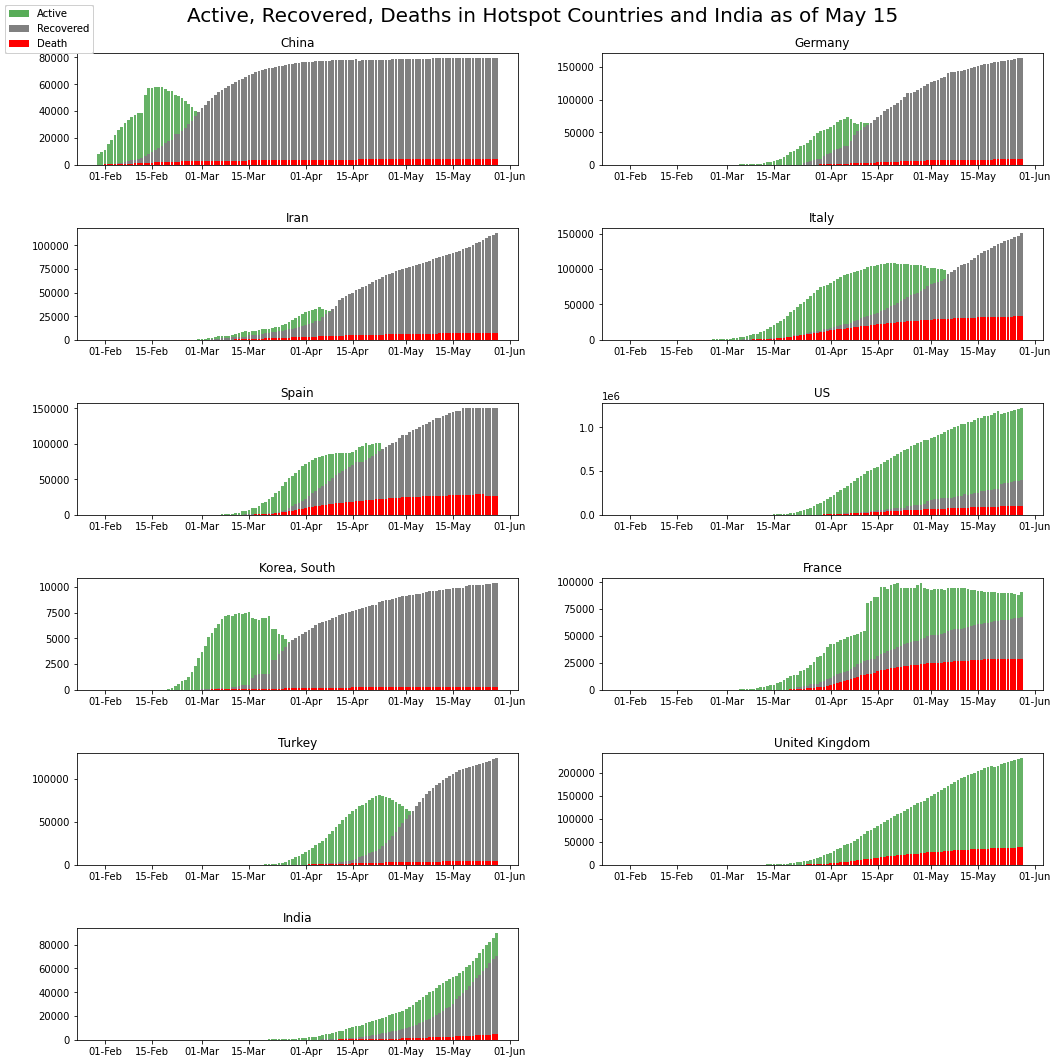

In [0]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of May 15',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

**Updates on India**

**Age Based Analysis**

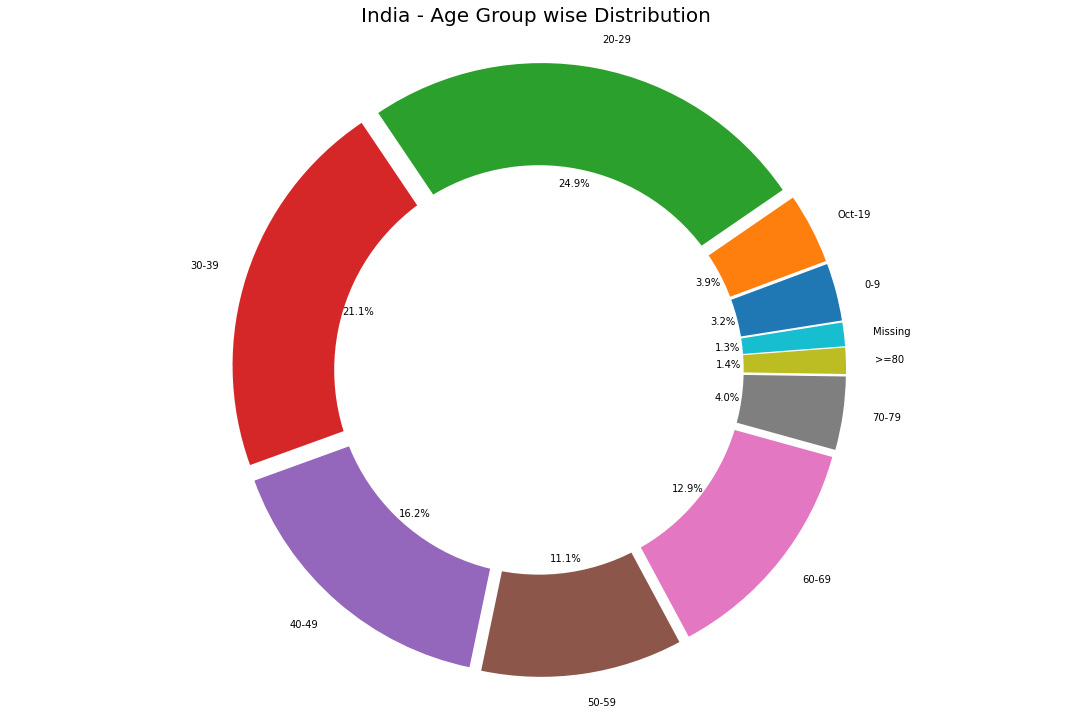

In [0]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

**Gender Based Analysis(Although 80% of the patient gender information is missing)**

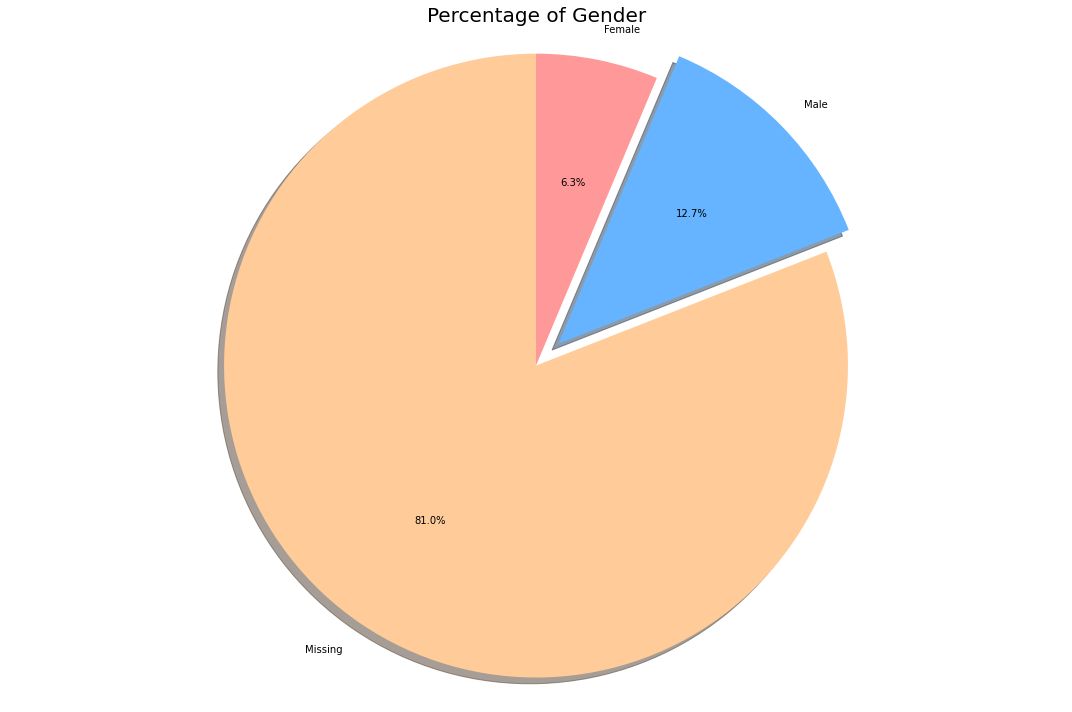

In [0]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

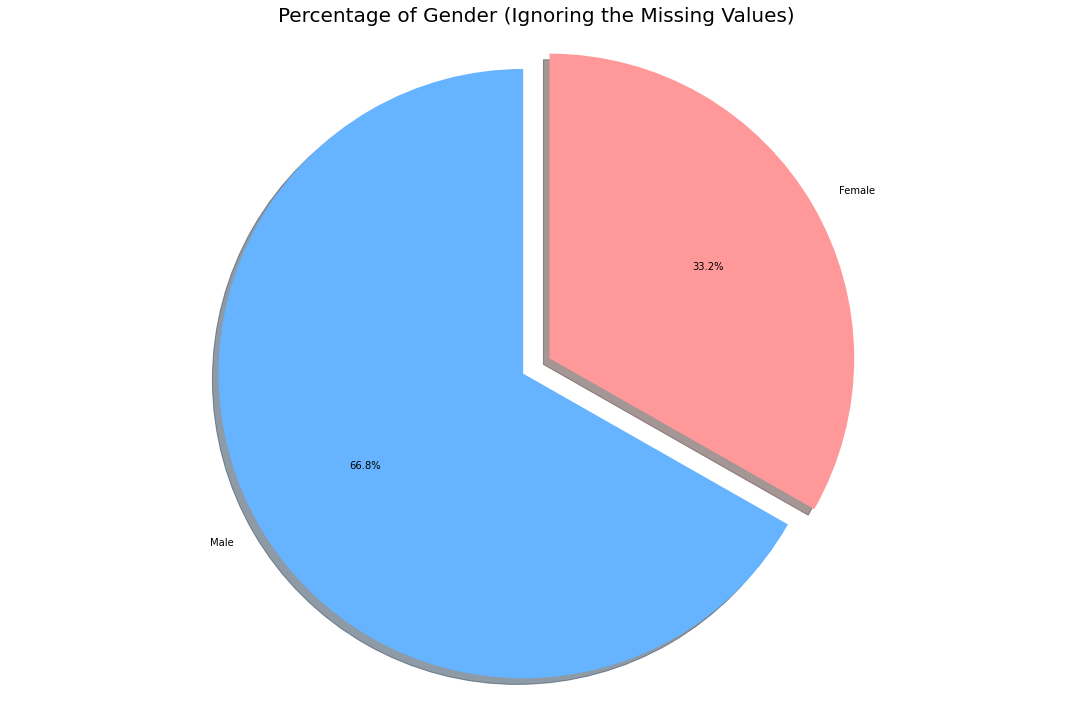

In [0]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])

explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']

plt.figure(figsize= (15,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 20)
plt.axis('equal')
plt.tight_layout()

**Statewise Insights**

In [0]:
state_cases = india_covid19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
20,Maharashtra,56948,1897,17918,37133,3.330000,31.460000
30,Tamil Nadu,18545,133,9909,8503,0.720000,53.430000
9,Delhi,15257,303,7264,7690,1.990000,47.610000
11,Gujarat,15195,938,7549,6708,6.170000,49.680000
28,Rajasthan,7703,173,4457,3073,2.250000,57.860000
19,Madhya Pradesh,7261,313,3927,3021,4.310000,54.080000
34,Uttar Pradesh,6991,182,3991,2818,2.600000,57.090000
5,Cases being reassigned to states,4332,0,0,4332,0.000000,0.000000
36,West Bengal,4192,289,1578,2325,6.890000,37.640000
1,Andhra Pradesh,3171,58,2057,1056,1.830000,64.870000


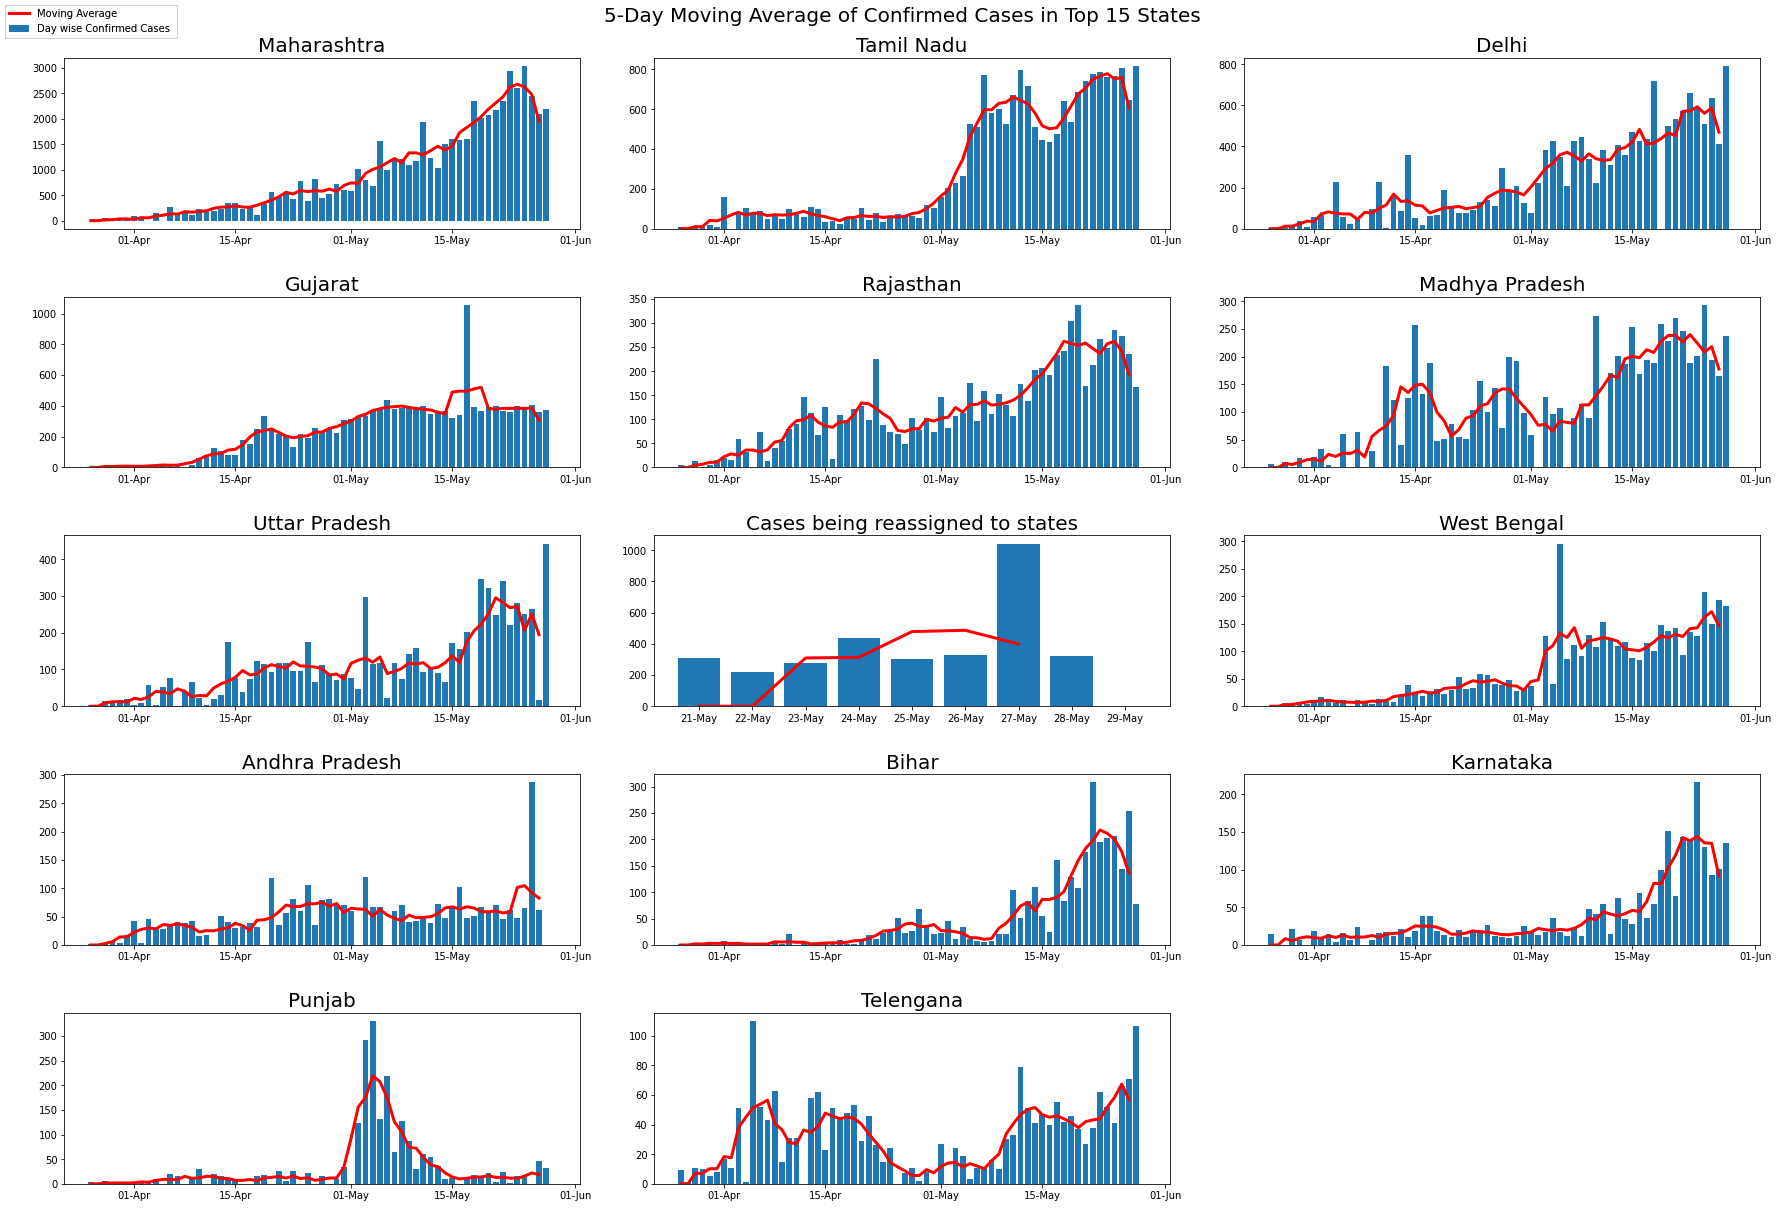

In [0]:
all_state = list(india_covid19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
#all_state.remove('Nagaland#')
#all_state.remove('Nagaland')
latest = india_covid19[india_covid19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calc_movingaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves

fig = plt.figure(figsize= (25,17))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    moving_aves = calc_movingaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='red',label = 'Moving Average',linewidth =3)  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

**The Spike in India**


In [0]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

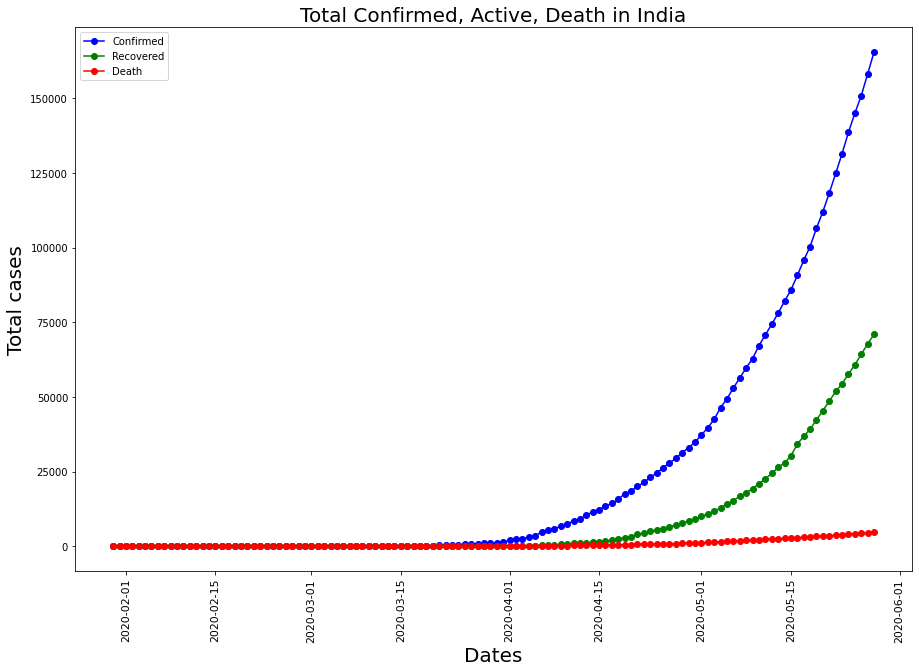

In [0]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

**Comparison with other Countries**

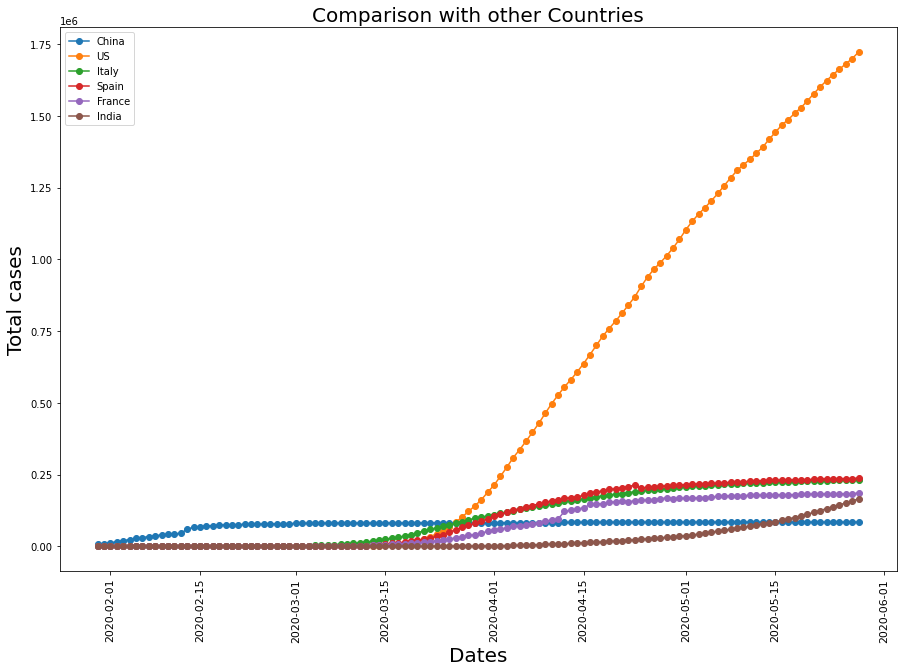

In [0]:
countries = ['China','US', 'Italy', 'Spain', 'France','India']

global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

**Prediction using Growth Factor
Here, we assume growth factor to be same for the next 15 days**

In [0]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 

growth_diff = []

for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])

growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.1284645941984761


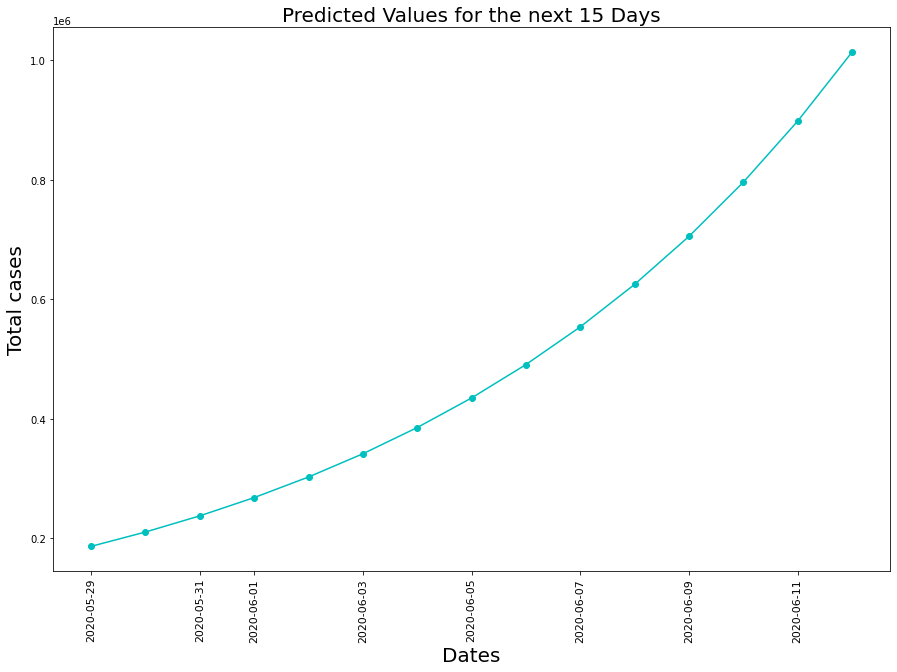

In [0]:
prediction_dates = []

start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []

for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

**Prediction using Prophet Model**

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


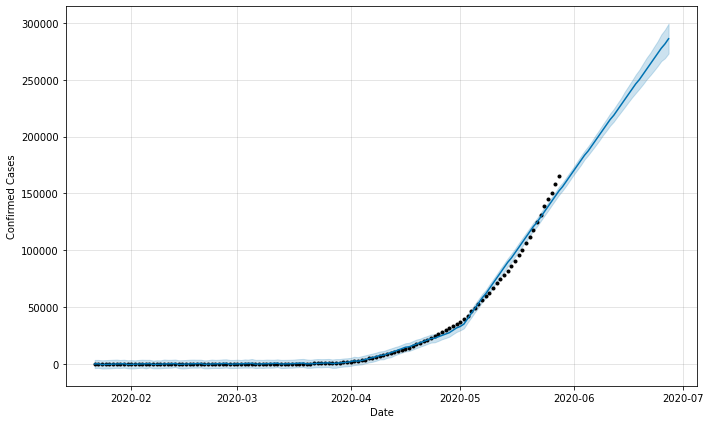

In [0]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)

fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

**Prediction Using Arima**

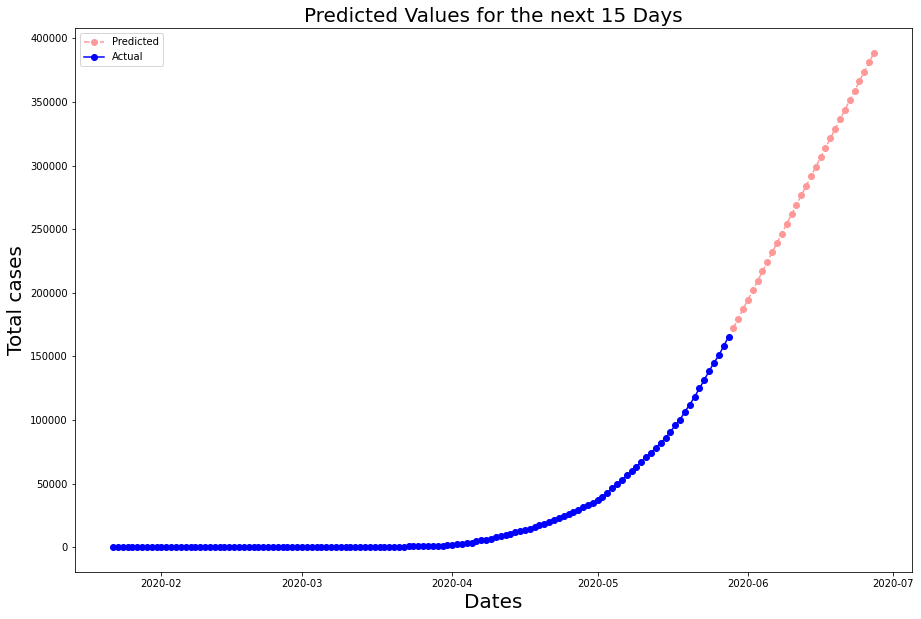

In [0]:
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();